In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import rc
rc('figure', figsize=(19,10))
from colorsys import hls_to_rgb
from tqdm import tqdm

In [2]:
def colorize(
    z,
    theme="dark",
    saturation=1.0,
    beta=1.4,
    transparent=False,
    alpha=1.0,
    max_threshold=1,
):
    r = np.abs(z)
    r /= max_threshold * np.max(np.abs(r))
    arg = np.angle(z)

    h = (arg + np.pi) / (2 * np.pi) + 0.5
    l = 1.0 / (1.0 + r**beta) if theme == "white" else 1.0 - 1.0 / (1.0 + r**beta)
    s = saturation

    c = np.vectorize(hls_to_rgb)(h, l, s)  # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0, 2)
    if transparent:
        a = 1.0 - np.sum(c**2, axis=-1) / 3
        alpha_channel = a[..., None] ** alpha
        return np.concatenate([c, alpha_channel], axis=-1)
    else:
        return c

## I. Parameters

In [3]:
## Parameters of the DMD
d = 7.6 # pitch in microns
theta = 12./180*np.pi
## Wavelength
_lambda = 0.633 # in microns
## Incident angle
alpha = 10./180*np.pi

## II. Modulation efficiency

The blazed grating equation then reads:

\begin{equation}
  \text{sin}(2\theta_B-\alpha) + \text{sin}(\alpha)
  = 2 \,\text{sin}(\theta)  \,\text{cos}(\theta-\alpha)
  = p\frac{\sqrt{2}\lambda}{d} \, ,
\end{equation}

with $p$ an integer, 
$\alpha$ the incident angle, 
$\theta$ the micro-mirrors angle (typically $\pm 12^\circ$), 
$d$ the pixel potch, 
and $\lambda the wavelength.

We can quantify how close we are to the ideal case,
i.e., when satisfying the blazed this equation,
by defining a {\em blazed number} $\mu$ as 

\begin{equation}
  \mu =
  \left| 4 \frac{d}{\sqrt{2}\lambda}
  \left[
    \text{sin}(\theta)\text{cos}(\theta-\alpha)
    \right]
  \mod{2} -1
  \right| \, ,
\end{equation}

where $\mod{2}$ represents the modulo 2 operation.
$\mu$ is maximal and equals $1$ when the blazing equation is satisfied,
i.e. when one order of diffraction contains most of the energy,
and minimal when we are in the worst-case scenario,
i.e. when four orders of diffraction have a significant and equal intensity.

### II.1 Computation of the *blazed number* $\mu$

In [4]:
## A simple criterion matching the diffraction angle and the reflection angle
def get_p(d, theta, _lambda, alpha):
    _beta = lambda alpha: 2*theta-alpha
    d_2D = d/np.sqrt(2)
    # return lambda alpha: d_2D/_lambda *(np.sin(alpha)+np.sin(_beta(alpha)))
    # or
    return 2*d_2D/_lambda *np.sin(theta)*np.cos(theta-alpha)

# when p is an integer, we are at a blazing angle with a maximum of energy at the order along the optical axis
# whem p is n+1/2, the enregy is spread over many diffraction orders not aligned with the optical axis

In [5]:
# test different incident angles
alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)

def get_mu(d, theta, _lambda, alpha):
    p = get_p(d, theta, _lambda, alpha)
    # return lambda alpha: np.abs(np.mod(2*p(alpha),2)-1)
    return np.abs(np.mod(2*p,2)-1)

f_mu = lambda alpha: get_mu(d, theta, _lambda, alpha)
criterion = np.fromiter((f_mu(a) for a in alpha_vec), float)

alpha1 = -15./180*np.pi
alpha2 = 0

### II.2 Dependence of $\mu$ with the pixel pitch and incident angle $\alpha$



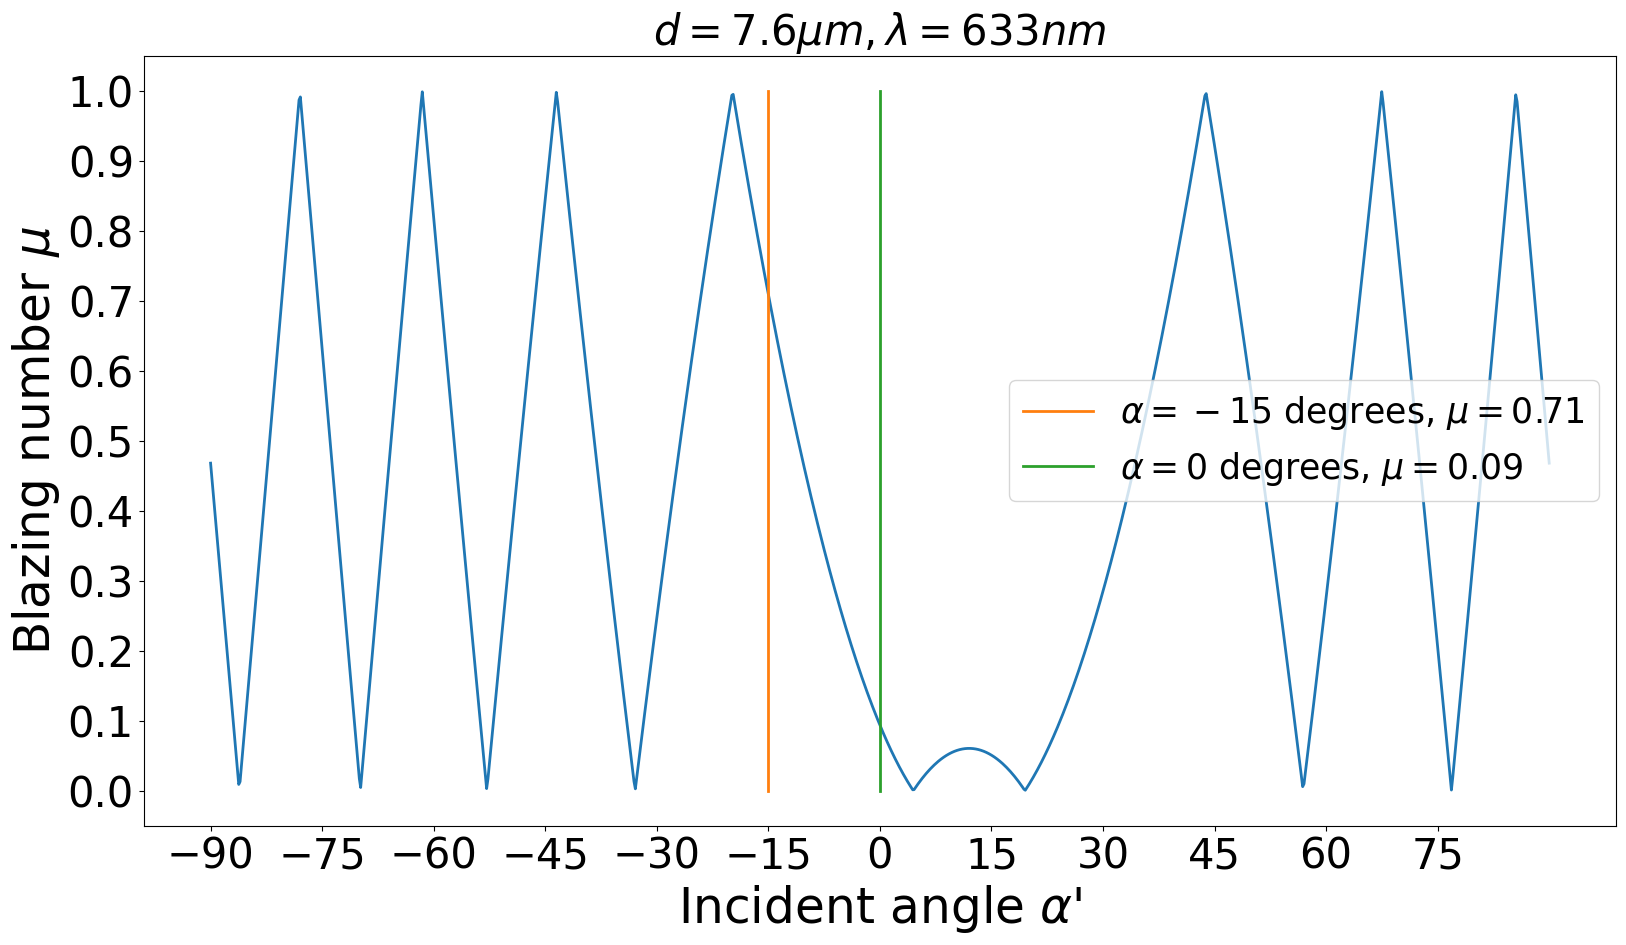

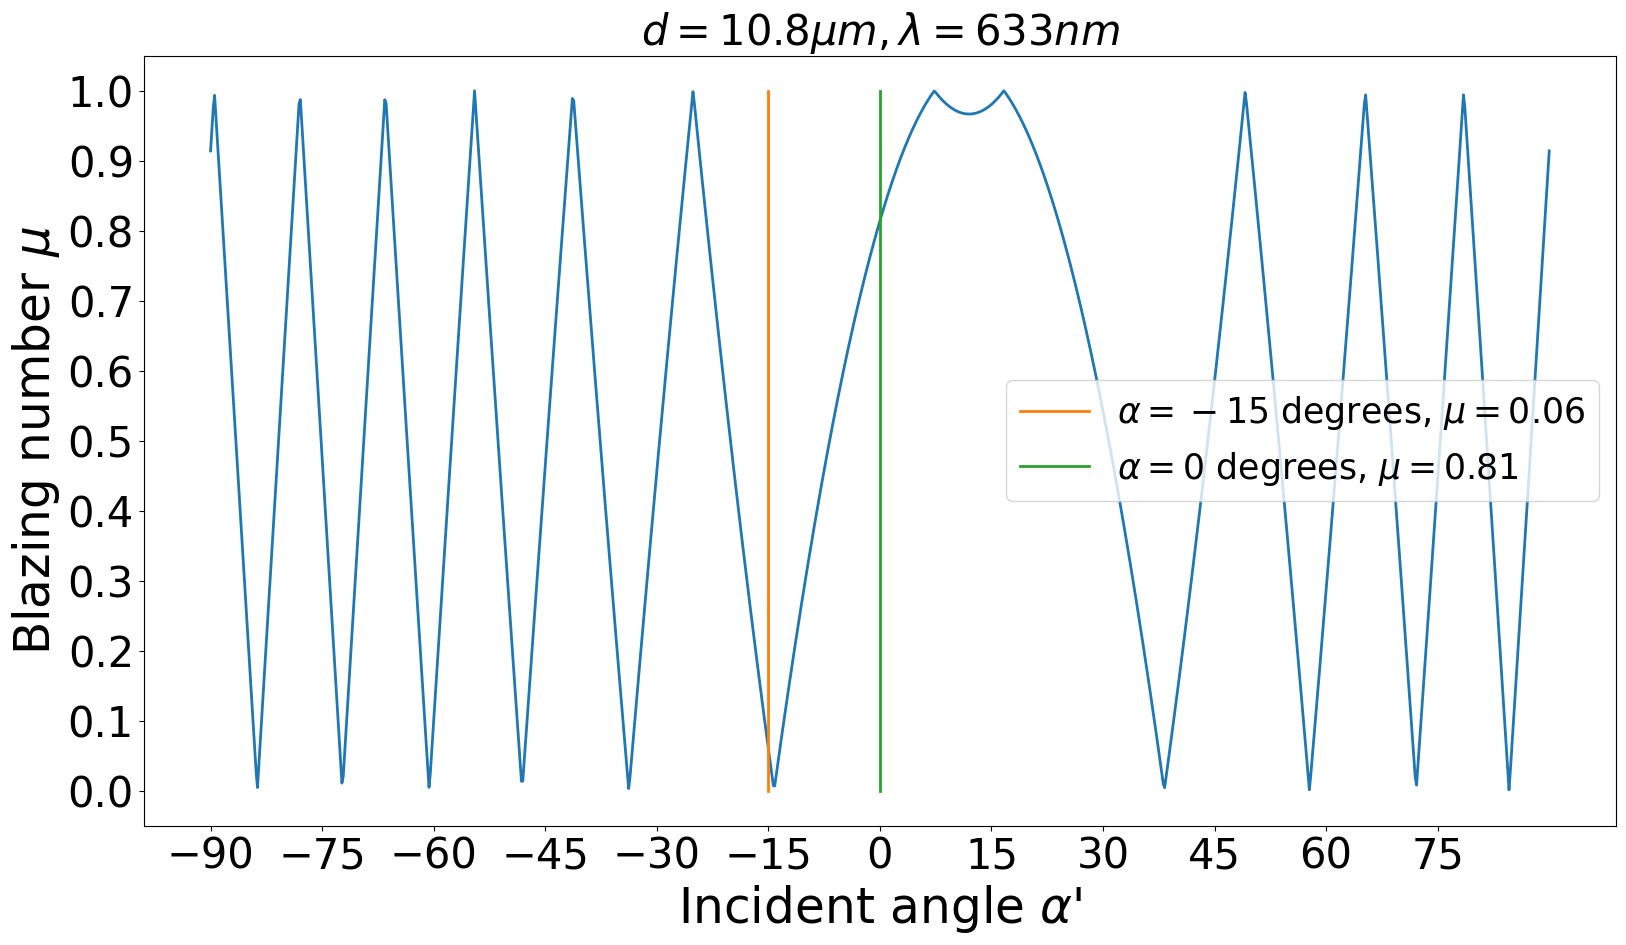

In [6]:

def show_mu(d, theta, _lambda, alphas):
    max_val = 1

    f_mu = lambda alpha: get_mu(d, theta, _lambda, alpha)
    
    alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)

    criterion = np.fromiter((f_mu(a) for a in alpha_vec), float)

    plt.figure()
    plt.plot(alpha_vec*180/np.pi,criterion,linewidth = 2)

    def get_label(alpha):
        label =  rf'$\alpha = {alpha*180/np.pi:.0f}$ degrees, $\mu = {f_mu(alpha):.2f}$'
        return label
    for alpha in alphas:
        plt.plot([alpha*180/np.pi]*2,[0.,max_val],label = get_label(alpha), linewidth = 2)
        
    plt.xticks(np.arange(-90,90,15),fontsize = 30)
    plt.yticks(np.arange(0,max_val+0.05,0.1),fontsize = 30)
    plt.title(r'$d=%.1f\mu m, \lambda =%g nm$' % (d,1e3*_lambda),fontsize = 30)
    plt.legend(fontsize = 25,loc='center right')
    plt.ylabel(r'Blazing number $\mu$', fontsize = 35)
    plt.xlabel(r"Incident angle $\alpha$'", fontsize = 35)
    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta*180/np.pi:.1f}_lambda{_lambda:.3f}'
    plt.savefig(image_prefix+'_mu.svg', dpi = 300)

d = 7.6
show_mu(d, theta, _lambda, alphas = [alpha1,alpha2])
d2 = 10.8
show_mu(d2, theta, _lambda, alphas = [alpha1,alpha2])

### Comparison with some experimental data

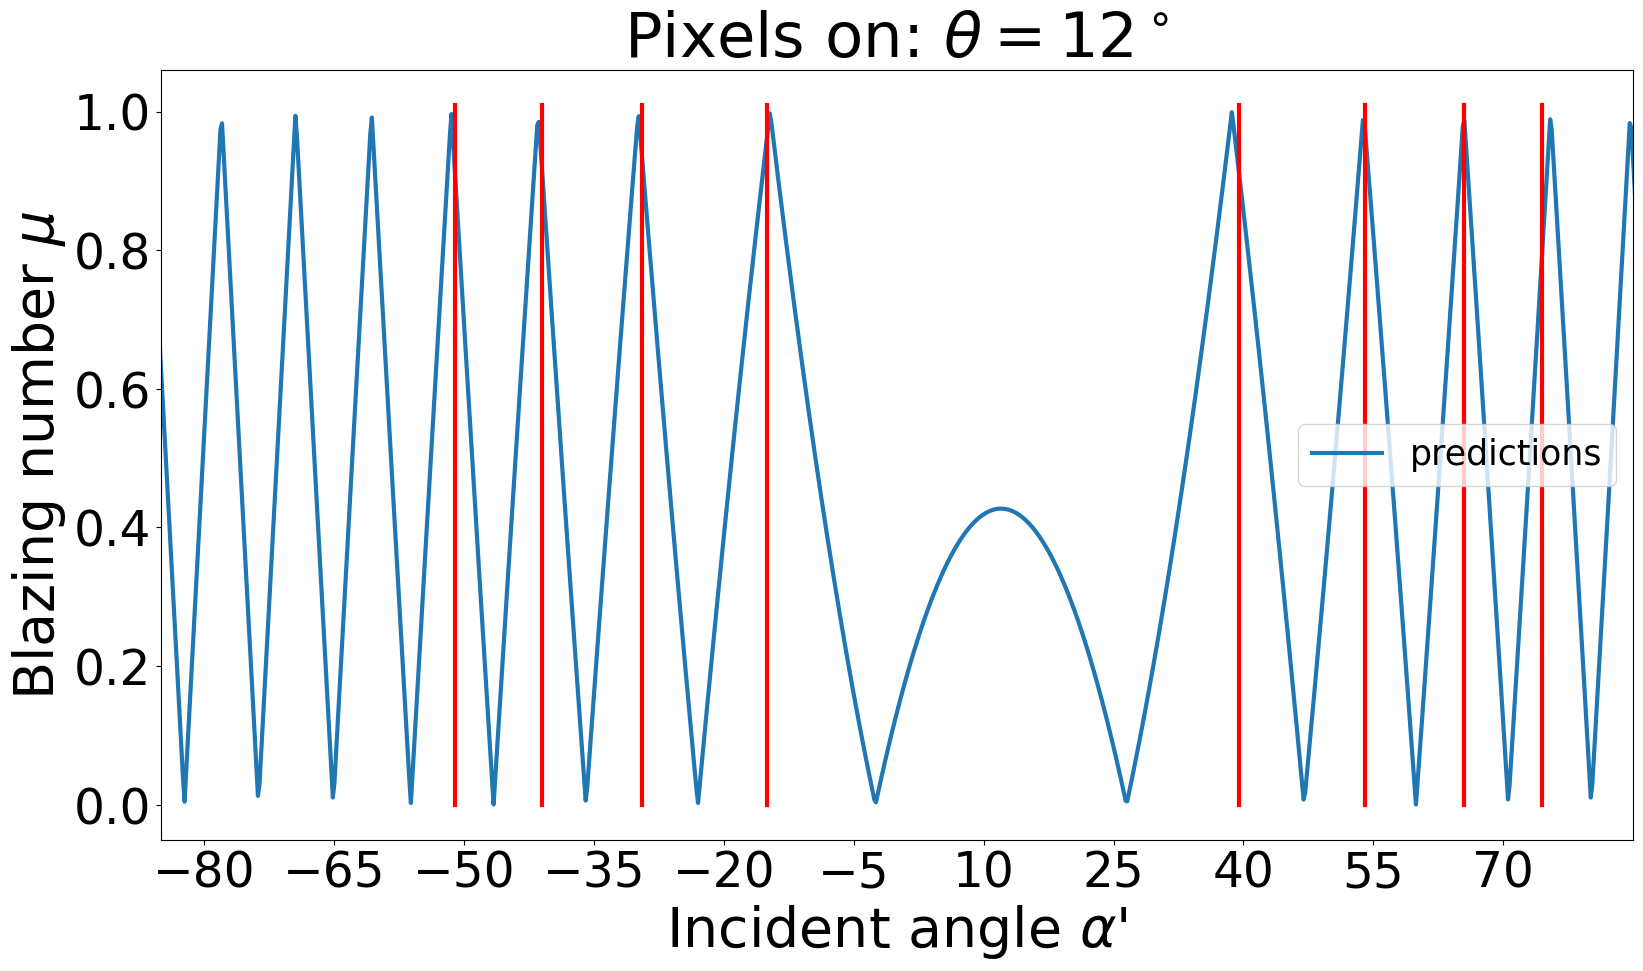

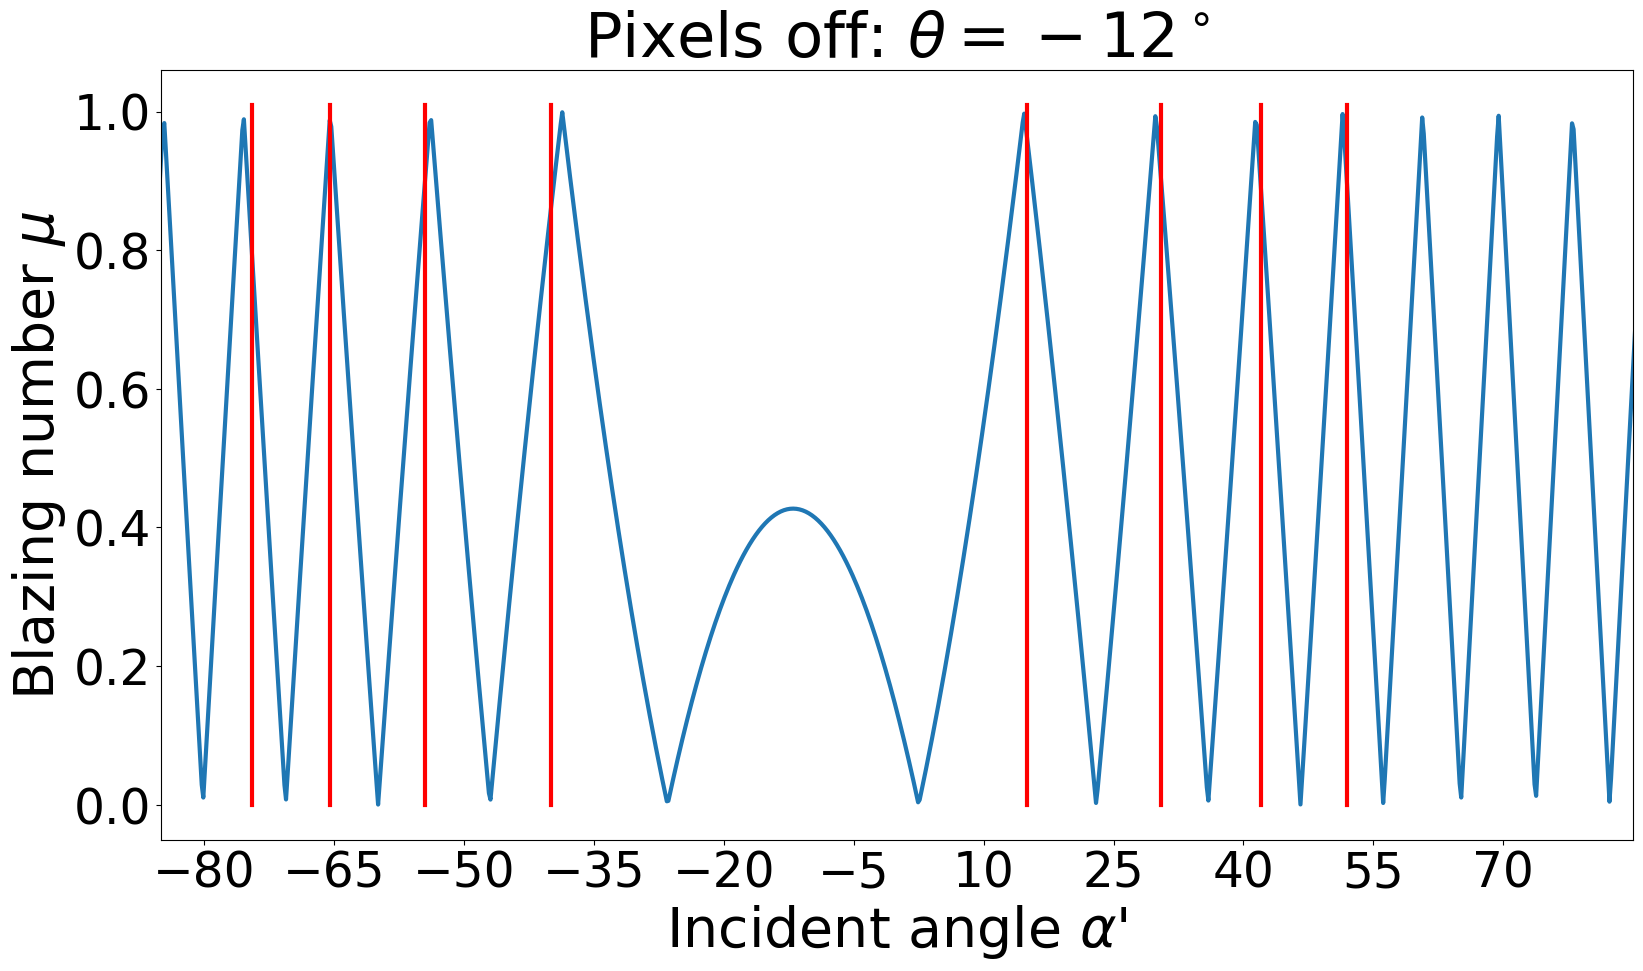

In [7]:
alpha_measured = -np.array([-51., -41, -29.5, -15, 39.5, 54, 65.5, 74.5])*1/180*np.pi
alpha_measured_off = np.array([52, 42, 30.5, 15, -40, -54.5, -65.5, -74.5])*1/180*np.pi

def show_mu(d, theta, _lambda):
    max_val = 1

    f_mu = lambda alpha: get_mu(d, theta, _lambda, alpha)
    
    alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)

    criterion = np.fromiter((f_mu(a) for a in alpha_vec), float)

    plt.figure()
    plt.plot(alpha_vec*180/np.pi,criterion,linewidth = 3, label = "predictions")

    plt.xticks(np.arange(-80,80,15),fontsize = 35)
    plt.xlim(-85,85)
    plt.yticks(np.arange(0,max_val+0.05,0.2),fontsize = 35)
    
    plt.ylabel(r'Blazing number $\mu$', fontsize = 40)
    plt.xlabel(r"Incident angle $\alpha$'", fontsize = 40)


show_mu(d2, theta, _lambda = 0.473)
max_val = 1.01
for a in -alpha_measured:
    plt.plot([a*180/np.pi]*2,[0.,max_val], linewidth = 3, color = 'red')

plt.title(r'Pixels on: $\theta=12^\circ$',fontsize = 45)
plt.legend(fontsize = 25,loc='center right')
plt.savefig('theo_VS_exp_diffraction.svg', dpi = 300)

show_mu(d2, -theta, _lambda = 0.473)
max_val = 1.01
for a in alpha_measured_off:
    plt.plot([a*180/np.pi]*2,[0.,max_val], linewidth = 3, color = 'red')

plt.title(r'Pixels off: $\theta=-12^\circ$',fontsize = 45)
plt.savefig('theo_VS_exp_diffraction_off.svg', dpi = 300)

### II.3 Dependence of $\mu$ with the wavelength $\lambda$

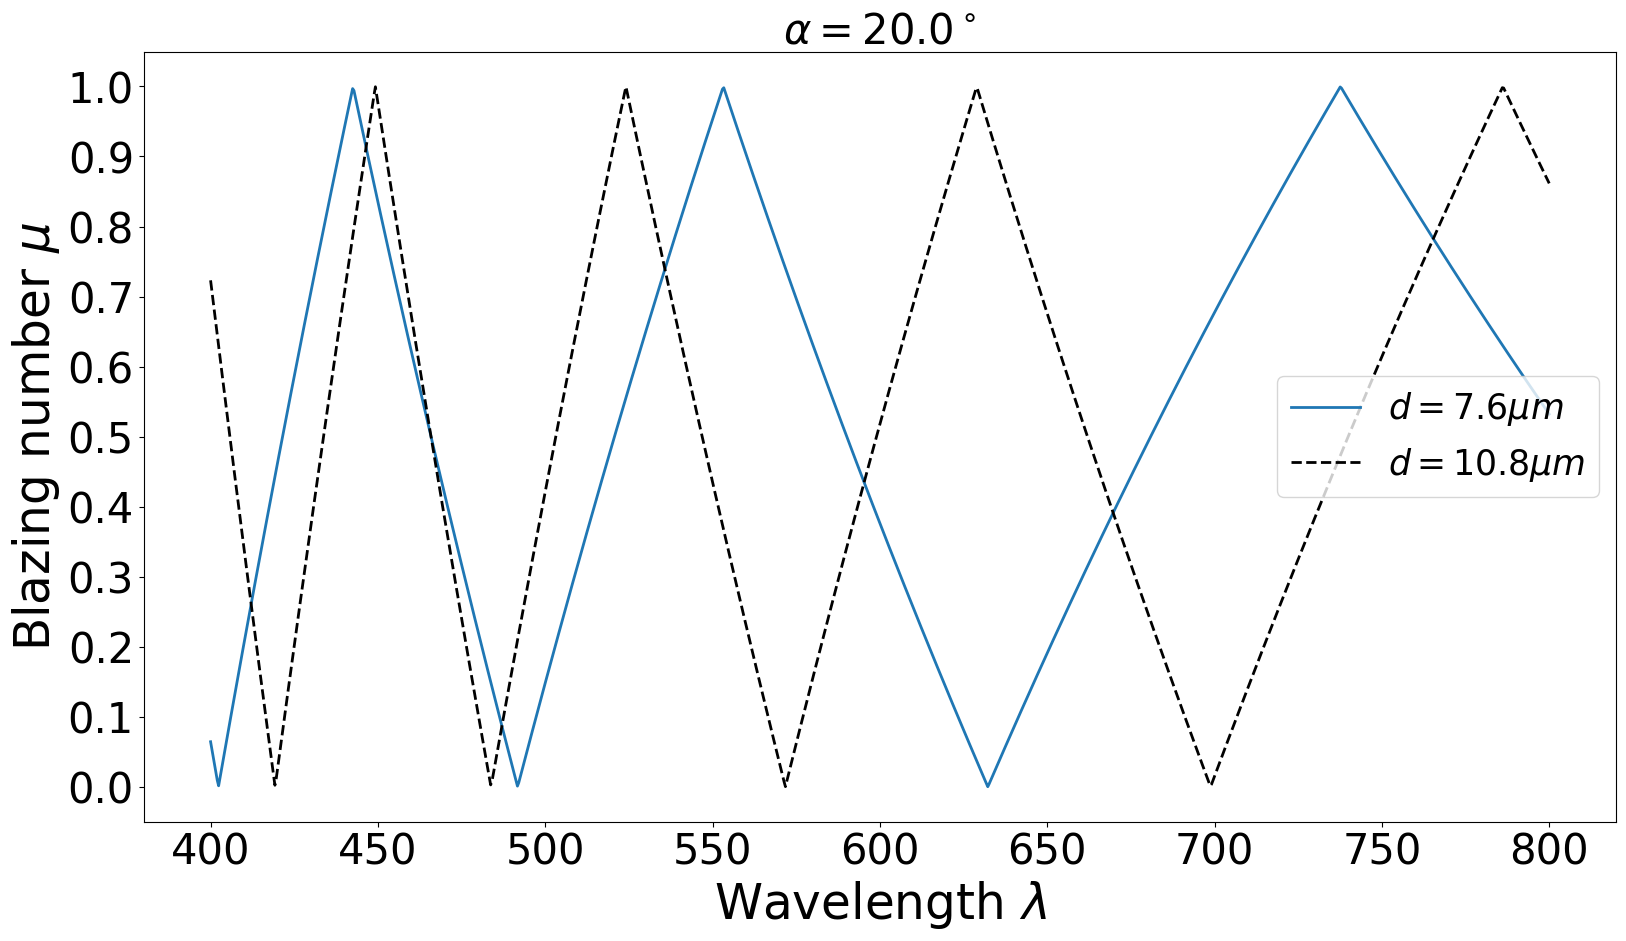

In [8]:
_lambda_vec = np.linspace(.4,.8,1000)
alpha = 20*np.pi/180
max_val = 1

d = 7.6
d2 = 10.8

f_mu = lambda _lambda: get_mu(d, theta, _lambda, alpha)
f_mu2 = lambda _lambda: get_mu(d2, theta, _lambda, alpha)

criterion_lambda_d = np.fromiter((f_mu(_lambda) for _lambda in _lambda_vec), float)
criterion_lambda_d2 = np.fromiter((f_mu2(_lambda) for _lambda in _lambda_vec), float)

plt.figure()
plt.plot(_lambda_vec*1e3,criterion_lambda_d,linewidth = 2, label = rf'$d = {d:.1f}\mu m$')
plt.plot(_lambda_vec*1e3,criterion_lambda_d2,'k--', linewidth = 2, label = rf'$d = {d2:.1f}\mu m$')

plt.xticks(fontsize = 30)
plt.yticks(np.arange(0,max_val+0.05,0.1),fontsize = 30)
plt.title(r'$\alpha =' + str(alpha*180/np.pi) + '^\circ$' ,fontsize = 30)

plt.ylabel(r'Blazing number $\mu$', fontsize = 35)
plt.xlabel(r'Wavelength $\lambda$', fontsize = 35)
plt.legend(fontsize = 25,loc='center right')
image_prefix = f'blazing_angle_d{d:.1f}_alpha{_lambda:.1f}_alpha{alpha:.1f}'
plt.savefig(image_prefix+'_mu.svg', dpi = 300)

### II.4 Dependence of $\mu$ with the wavelength and the incident angle $\alpha$

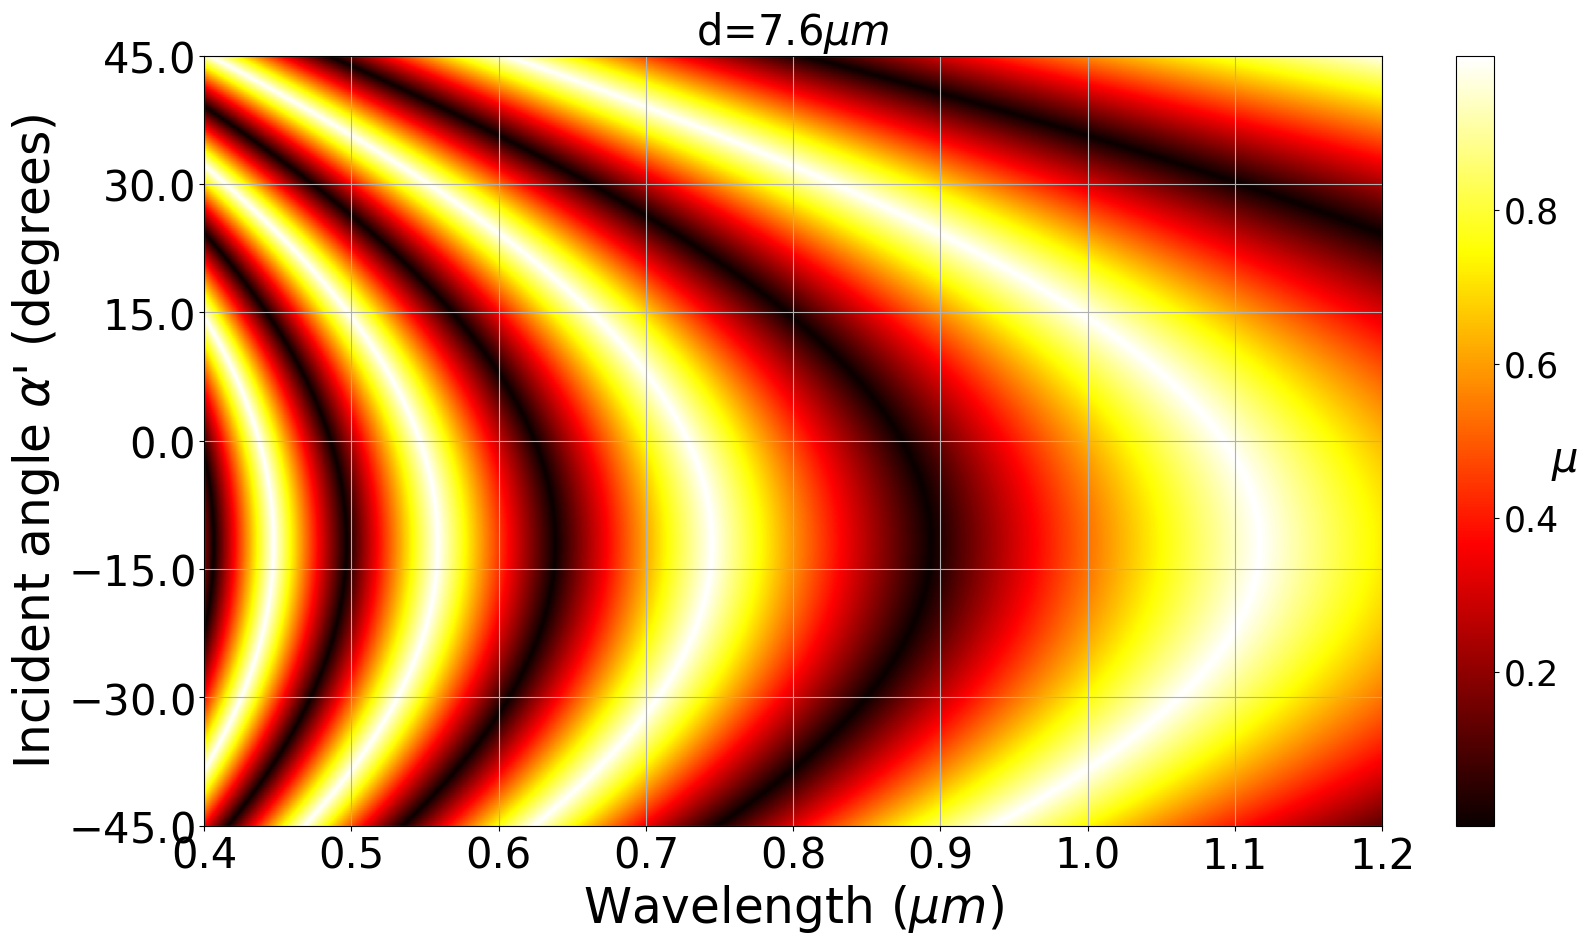

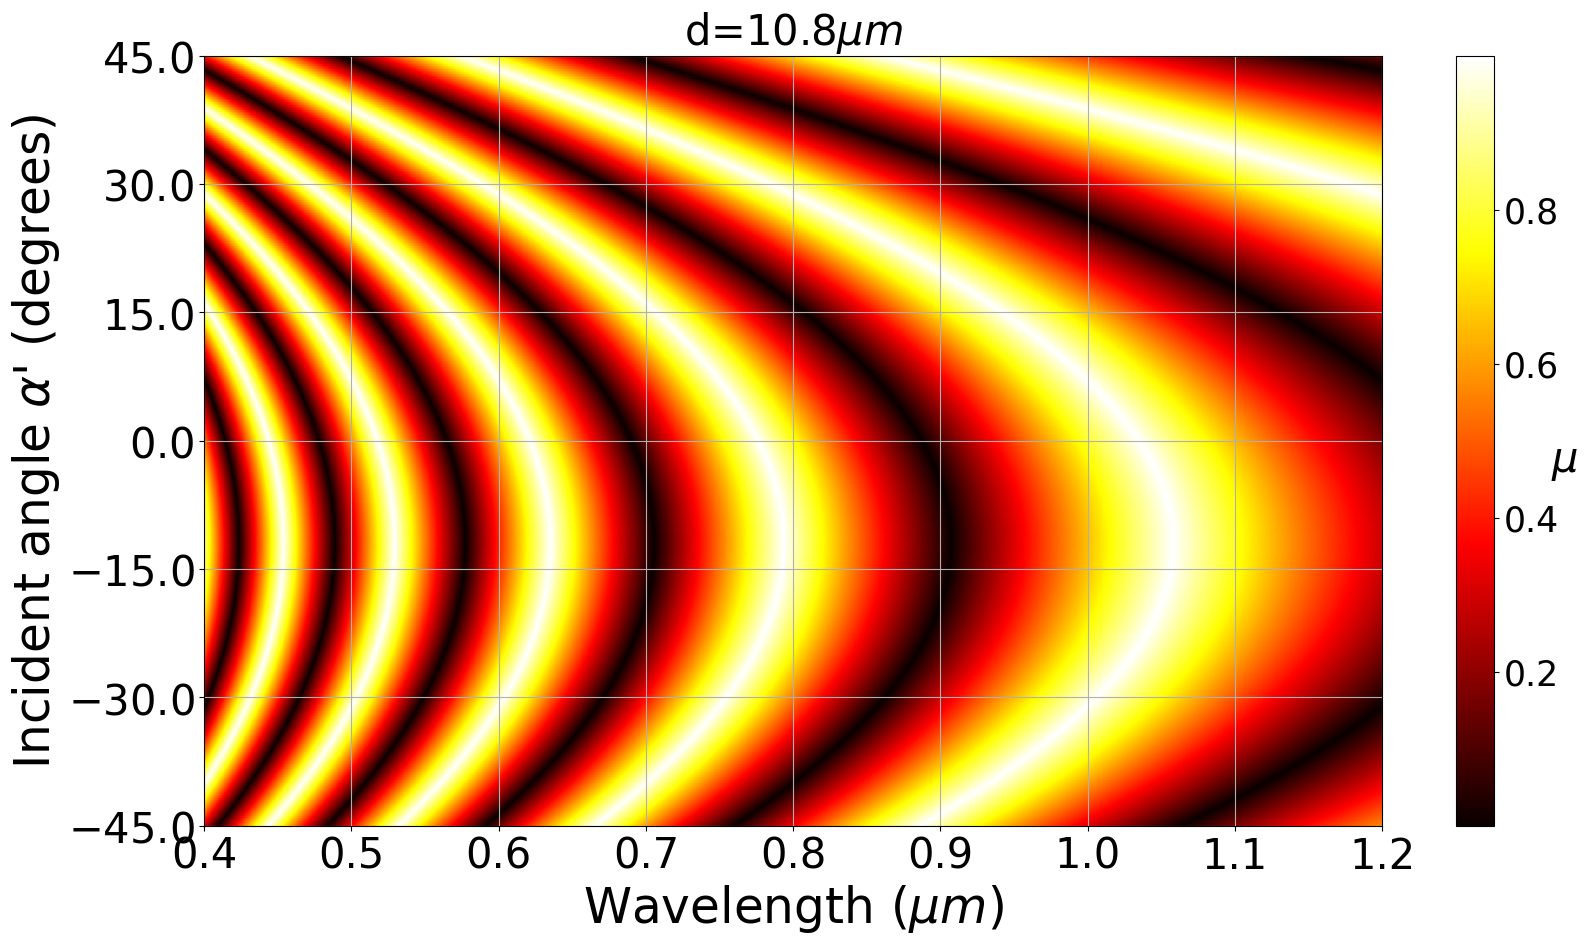

In [9]:
def show_mu_2d(d, theta):
    lambda_vec = np.linspace(0.4,1.2,1000)
    alpha_vec = np.linspace(-np.pi/4,np.pi/4,300)

    L,A1D = np.meshgrid(lambda_vec,alpha_vec)
    f_mu = lambda _lambda, alpha: get_mu(d, theta, _lambda, alpha)

    C = np.fromiter((f_mu(l,a) for l,a in zip(L.flatten(),A1D.flatten())), float).reshape(L.shape)

    plt.figure()
    plt.imshow(C, extent=[lambda_vec[0],lambda_vec[-1],alpha_vec[0],alpha_vec[-1]], aspect='auto', cmap = 'hot')
    plt.grid(True)
    plt.xlabel(r'Wavelength ($\mu m$)', fontsize=35)
    plt.xticks(fontsize=30)
    plt.ylabel(r"Incident angle $\alpha$' (degrees)", fontsize=35)
    ticks_degrees = np.linspace(-45,45,7)
    ticks_radians = ticks_degrees/180*np.pi
    plt.yticks(ticks_radians, [r'$'+str(t)+'$' for t in ticks_degrees], fontsize=30)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=25)
    cb.set_label(rotation = 0, label=r'$\mu$',size=30,weight='bold')
    plt.title(r'd=$%.1f\mu m$' % (d),fontsize = 30)
    plt.savefig(f'mu_2d_{d}.svg')

d = 7.6
show_mu_2d(d, theta)
d2 = 10.8
show_mu_2d(d2, theta)

## III. Simulation of the 2D far field pattern 

### III.1 Compute far field diffraction pattern

In [10]:
## A full numerical simulation of the Fourier plane for an all-on configuration

N = 10 # number of mirrors in each direction
g = 0 # gap between pixels in micron
res = 20 # pixels per mirror (for numerical calculation)
Nx = N*res

filling_fraction = d**2/(d+g)**2*100
print(f'filling fraction = {filling_fraction:.1f}%')

filling fraction = 100.0%


Text(0.5, 1.0, 'Far field, Energy efficiency = 17.43%')

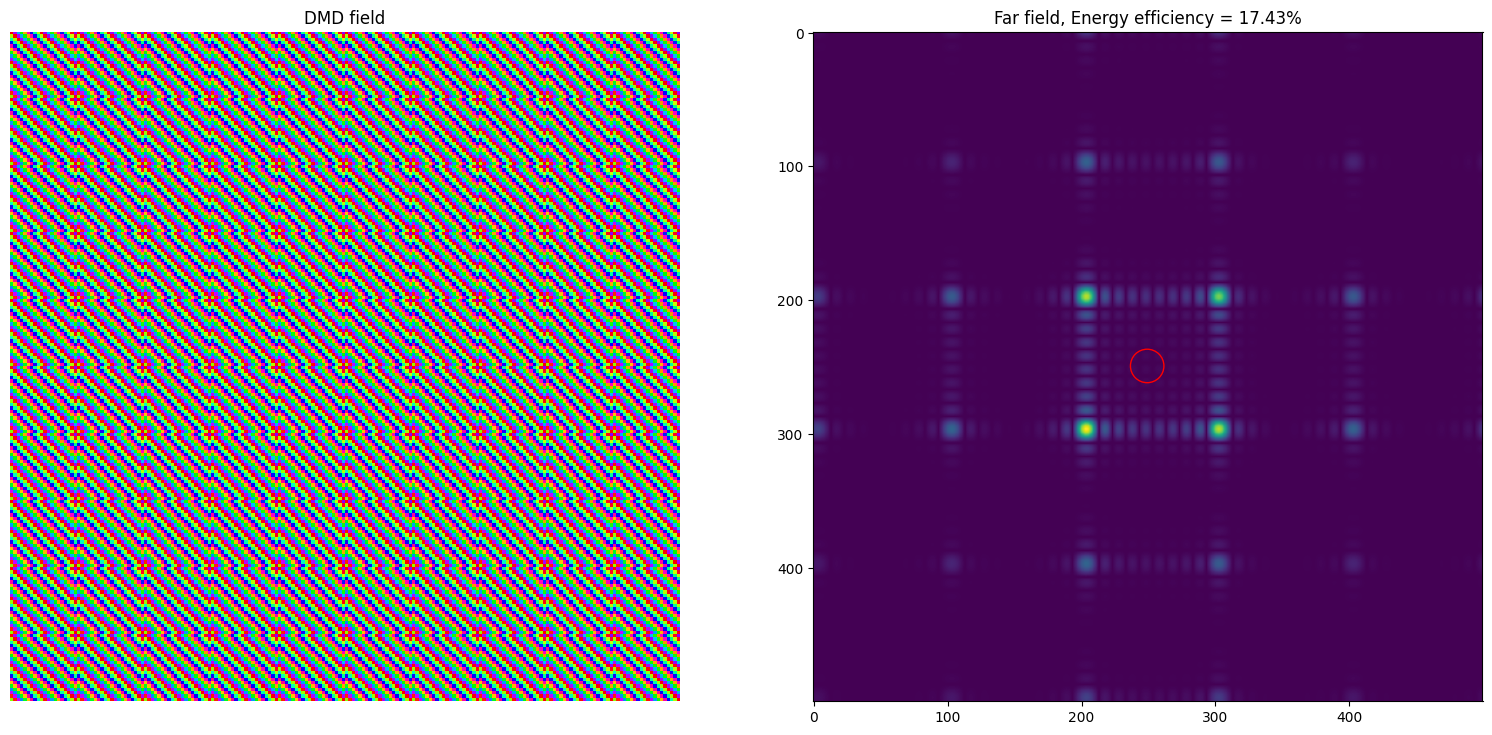

In [11]:
d = 10.8
theta = theta
_lambda = 0.633
alpha =  alpha1

def get_complex_field_on_normal_mirror(d,_lambda, alpha):
    beta = -alpha +2*theta # reflection angle
    X_vec = np.arange(Nx)/res*d
    X,Y = np.meshgrid(X_vec,X_vec)
    X_new = (X-Y)/np.sqrt(2)
    k = 2*np.pi/_lambda
    phi_in = k*X_new*np.sin(alpha)
    phi_out = k*X_new*np.sin(beta)


    ## Mirror image
    MI = np.exp(1j*(phi_in+phi_out))
    return MI


def get_complex_field_on_DMD(d, theta, _lambda, alpha):
    beta = -alpha +2*theta # reflection angle

    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta*180/np.pi:.1f}_lambda{_lambda:.1f}_alpha{alpha*180/np.pi:.1f}'

    ## Pixelate image function: value 0/1 on each mirror
    f = np.ones([N,N]) # all-on configuration

    ## Mirror image
    MI = np.zeros([Nx,Nx], dtype='complex')

    # On each cell-unit, i.e. each mirror, 
    # We compute the phase due to the incident + reflection angle
    # Each unit cell has the same slope repeated with a pitch d

    Cell = np.zeros([res,res], dtype='complex')
    gpix = int(np.round(g/(2.*d)*res))
    Cell[gpix:res-gpix,gpix:res-gpix] = 1.
        
    x_vec = np.arange(res)/res*d
    x,y = np.meshgrid(x_vec,x_vec)
    x_new = (x-y)/np.sqrt(2)

    k = 2*np.pi/_lambda

    # if there is a gap, we will only fill the central part of the cell
   
    Cell *= np.exp(1j*k*x_new*(np.sin(beta)+np.sin(alpha)))

    for i in range(N):
        for j in range(N):
            MI[i*res:(i+1)*res,j*res:(j+1)*res] = f[i,j]*Cell
    return MI


def get_far_field(DMD_field, coeff = 10):
    ## In the Fourier plane
    FP = np.fft.fftshift(np.fft.fft2(DMD_field,s=[coeff*Nx,coeff*Nx]))
    return FP

def get_efficiency_in_FF(FF, mask_diameter = 15):
    max_pos = np.argmax(np.abs(FF))
    # index unwrap
    max_pos = np.unravel_index(max_pos, FF.shape)
    np.abs(FF)[max_pos]
    X,Y = np.meshgrid(np.arange(FF.shape[0]),np.arange(FF.shape[1]))
    X -= max_pos[1]
    Y -= max_pos[0]
    R = np.sqrt(X**2+Y**2)
    disk_mask = (R<=mask_diameter/2).astype(int)

    Energy_efficiency = np.sum(np.abs(FF)**2*disk_mask)/np.sum(np.abs(FF)**2)
    return np.array(max_pos), disk_mask, Energy_efficiency

DMD_field = get_complex_field_on_DMD(d, theta, _lambda, alpha)
FF = get_far_field(DMD_field)
mask_diameter = 25
max_pos, disk_mask, Energy_efficiency = get_efficiency_in_FF(FF, mask_diameter)

# We also simulate a perfect mirror to find the reflection angle
Mirror_field = get_complex_field_on_normal_mirror(d,_lambda, alpha)
FF_mirror = get_far_field(Mirror_field)
pos_reflection, disk_mask, Energy_efficiency_mirror = get_efficiency_in_FF(FF_mirror, mask_diameter)

# to center the image around the specular reflection angle
def crop_center(img,center,witdh):
    center = np.round(np.array(center)).astype(int)
    return img[center[0]-witdh//2:center[0]+witdh//2,center[1]-witdh//2:center[1]+witdh//2]


ROI_size = 500
FF_crop = crop_center(np.abs(FF),pos_reflection,ROI_size)
FF_mirror_crop = crop_center(np.abs(FF_mirror),pos_reflection,ROI_size)

plt.figure()
plt.subplot(121)
plt.imshow(colorize(DMD_field))   
plt.title('DMD field')

plt.axis('off')
plt.subplot(122)
plt.imshow(np.abs(FF_crop))   
# circle = plt.Circle((pos_reflection[1], pos_reflection[0]), radius=mask_diameter/2, color='red', fill=False)
circle = plt.Circle(((ROI_size-1)//2,(ROI_size-1)//2) , radius=mask_diameter/2, color='red', fill=False)
plt.gca().add_patch(circle)
plt.title(f'Far field, Energy efficiency = {100*Energy_efficiency:.2f}%')


### III.2 Blazing number vs diffraction efficiency as a function of the incident angle $\alpha$

In [12]:
theta = 12./180*np.pi
d = 10.8
theta = 12*np.pi/180
_lambda = 0.473

In [13]:
def get_eff(d, theta, _lambda, alpha):
    ''' 
    Compute the diffraction efficiency for a given set of parameters
    '''
    DMD_field = get_complex_field_on_DMD(d, theta, _lambda, alpha)
    FF = get_far_field(DMD_field)
    return  get_efficiency_in_FF(FF, mask_diameter = 15)[2]


In [14]:
## Compute the efficiency for a range of incident angles

alpha_vec = np.linspace(-np.pi/2,np.pi/2,500)
def f_alpha (alpha):
    return get_eff(d, theta, _lambda, alpha)

eff_vec_alpha= [
    get_eff(d, theta, _lambda = _lambda, alpha = a) for a in tqdm(alpha_vec)
]    

100%|██████████| 500/500 [01:57<00:00,  4.27it/s]


**Compare simulations, predictions, and experimental results**

Text(0.5, 0, "Incident angle $\\alpha$'")

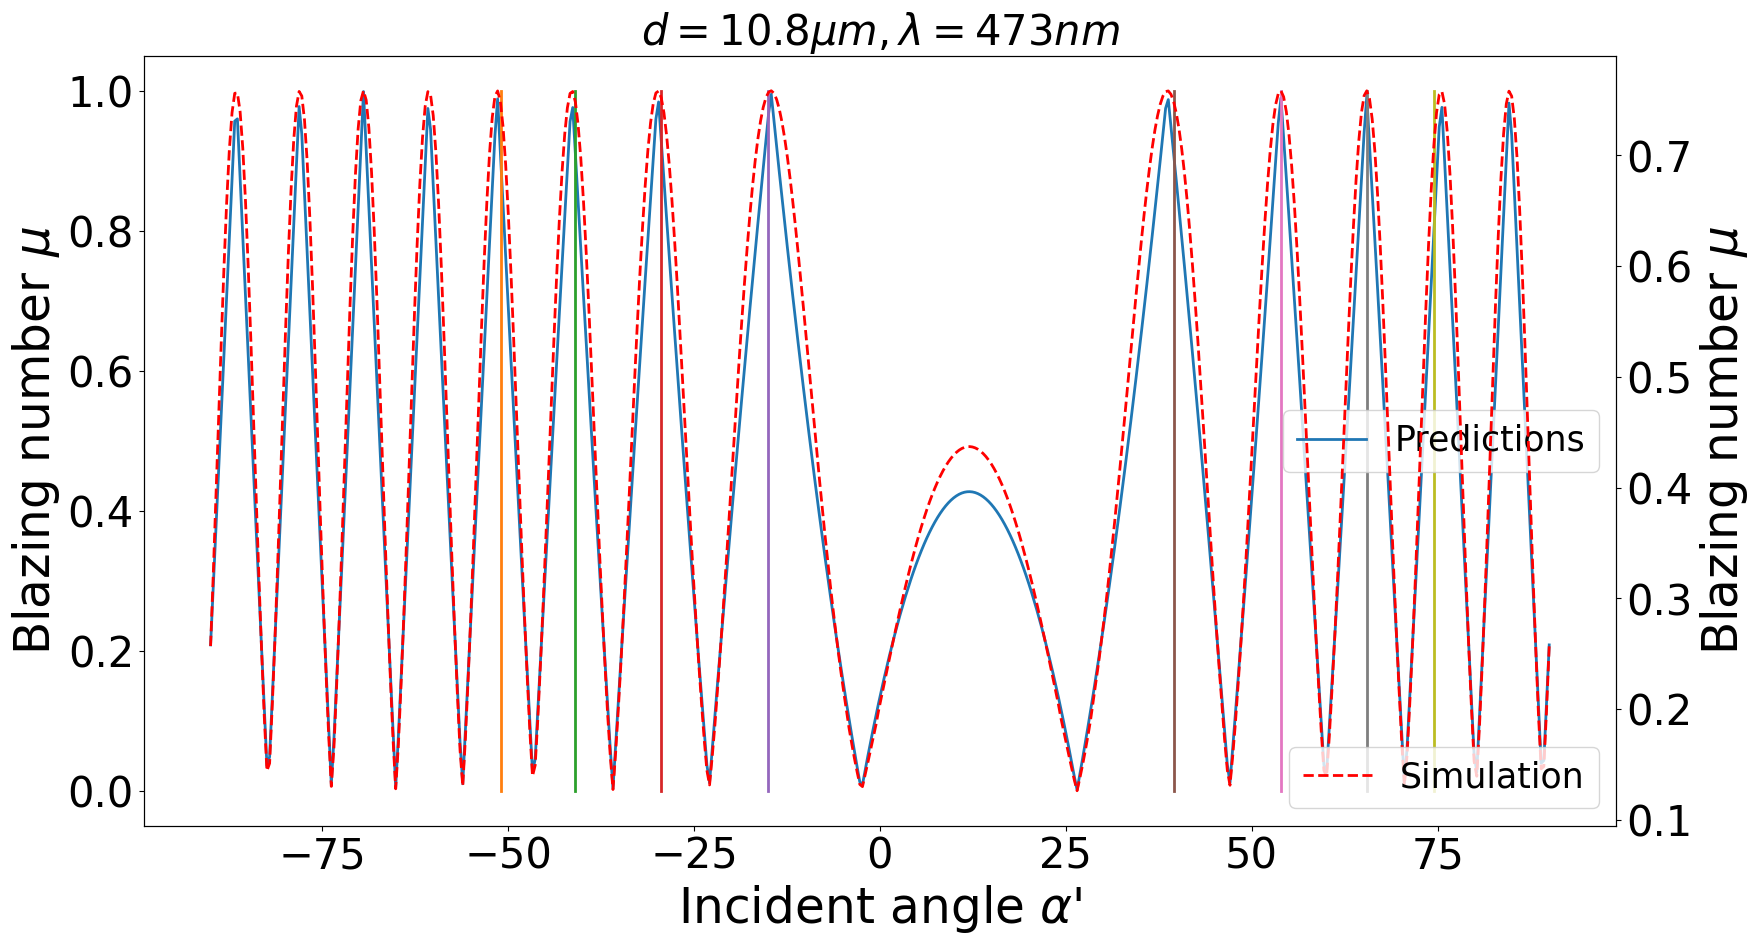

In [15]:

f_mu = lambda alpha: get_mu(d, theta, _lambda, alpha)
alphas = -alpha_measured


criterion = np.fromiter((f_mu(a) for a in alpha_vec), float)


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(alpha_vec*180/np.pi,criterion,linewidth = 2, label = "Predictions")
for alpha in alphas:
    ax1.plot([alpha*180/np.pi]*2,[0.,max_val], linewidth = 2)
ax1.set_ylabel(r'Blazing number $\mu$', fontsize = 35)
ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

eff_vec = np.array(eff_vec_alpha)
# Create the second set of axes sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(alpha_vec*180/np.pi,eff_vec_alpha,linewidth = 2, color = 'red', linestyle = '--', label = "Simulation")
ax2.set_ylabel('Diffraction efficiency', fontsize = 35)
ax2.tick_params(axis='y', labelsize=30)

# Add grid and legends
# fig.tight_layout()
ax1.legend(fontsize = 25,loc='center right')
ax2.legend(fontsize = 25,loc='lower right')


plt.title(r'$d=%.1f\mu m, \lambda =%g nm$' % (d,1e3*_lambda),fontsize = 30)
# plt.legend(fontsize = 25,loc='center right')
plt.ylabel(r'Blazing number $\mu$', fontsize = 35)
ax1.set_xlabel(r"Incident angle $\alpha$'", fontsize = 35)
# image_prefix = f'blazing_angle_d{d:.1f}_theta{theta:.1f}_lambda{_lambda:.1f}'
# plt.savefig(image_prefix+'_mu.svg', dpi = 300)

### III.3 Blazing number vs diffraction efficiency as a function of the wavelength

In [16]:
alpha = 0/180*np.pi
d = 7.6
lambda_vec = np.linspace(0.4,0.8,500)
f_mu = lambda _lambda: get_mu(d, theta, _lambda, alpha)


mu_vec = np.fromiter((f_mu(l) for l in lambda_vec), float)
eff_vec = [
    get_eff(d, theta, l, alpha) for l in tqdm(lambda_vec)
]

100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


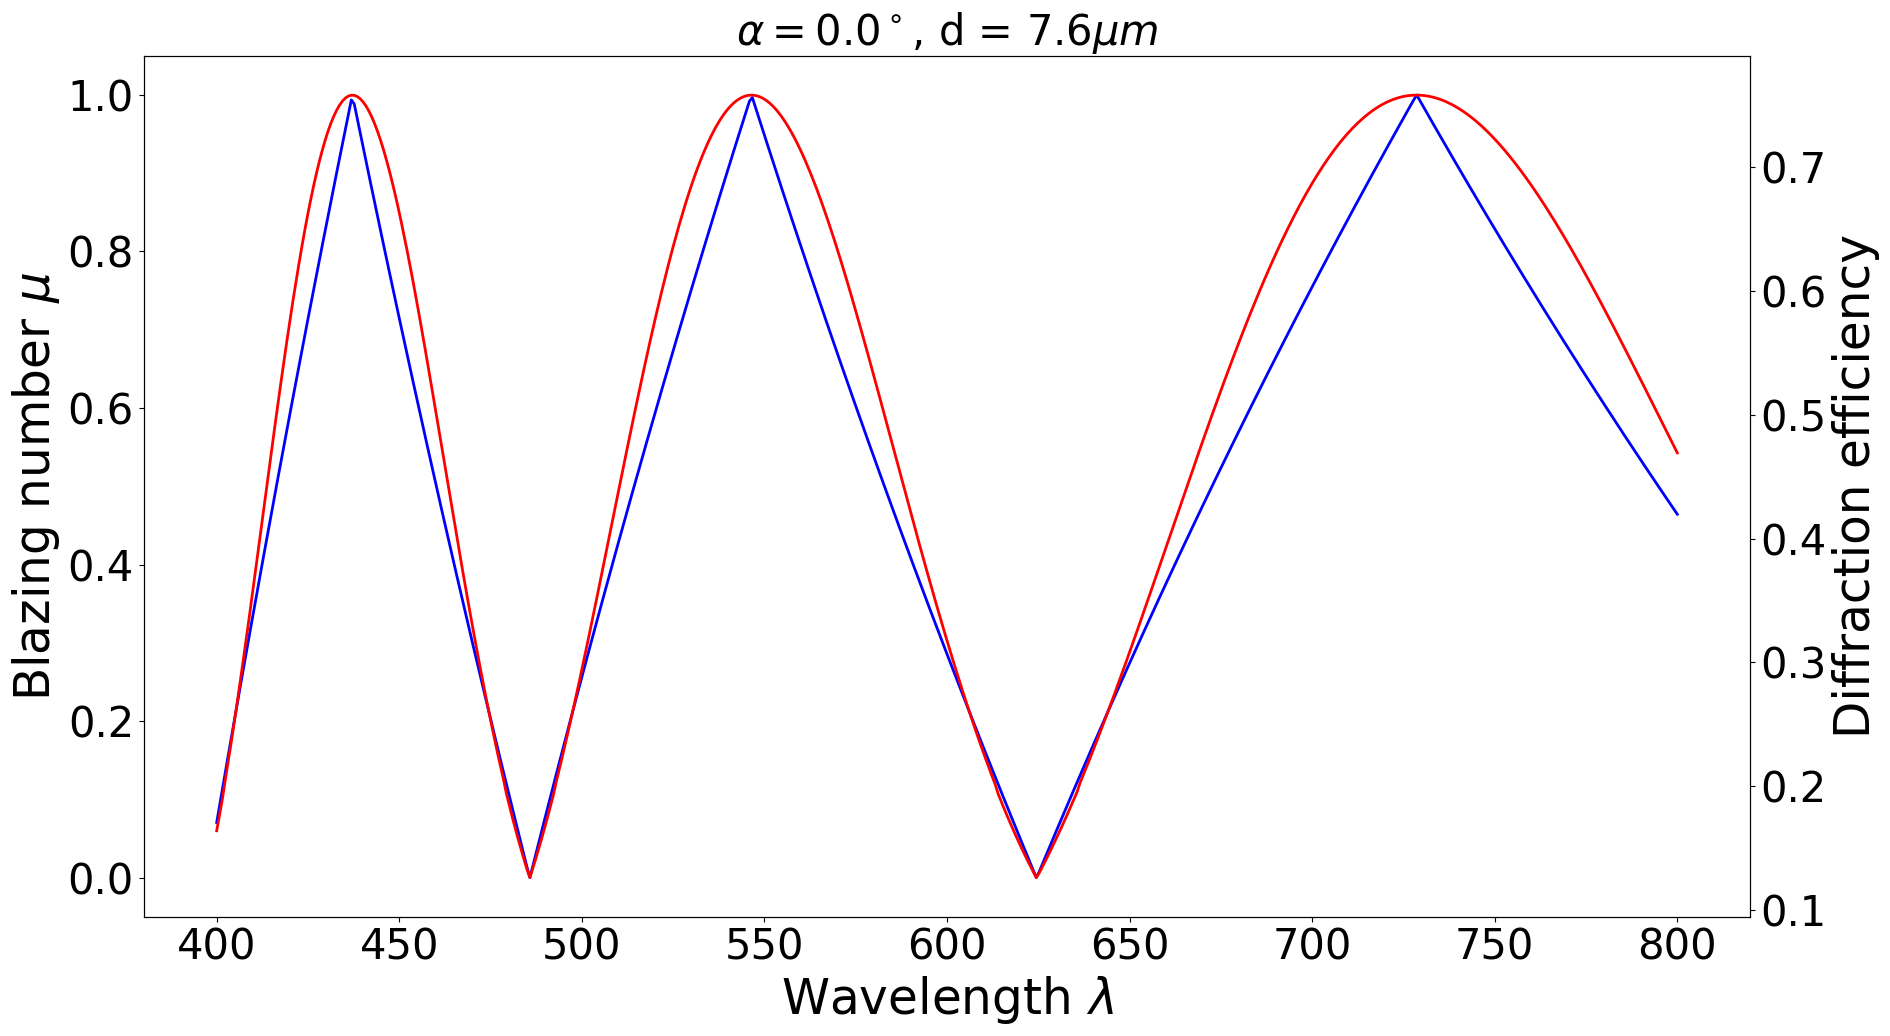

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(lambda_vec*1e3, mu_vec, linewidth=2, label=rf'$\mu$', color='b')
ax1.set_xlabel(r'Wavelength $\lambda$', fontsize = 35)
ax1.set_ylabel(r'Blazing number $\mu$', fontsize = 35)
ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

eff_vec = np.array(eff_vec)
# Create the second set of axes sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(lambda_vec*1e3, eff_vec, linewidth=2, color='r')
ax2.set_ylabel('Diffraction efficiency', fontsize = 35)
ax2.tick_params(axis='y', labelsize=30)

# Add grid and legends
fig.tight_layout()

plt.title(r'$\alpha =' + str(alpha*180/np.pi) + '^\circ$, ' + f'd = {d}' + r'$\mu m$' ,fontsize = 30)

plt.xlabel(r'Wavelength $\lambda$', fontsize = 35)
image_prefix = f'blazing_angle_d{d:.1f}_alpha{alpha:.1f}'
plt.savefig(image_prefix+'_mu_vs_diffeff.svg', dpi = 300)

### III.4 Show diffraction patterns

In [18]:
def show_2d(d, theta, _lambda, alpha):

    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta*180/np.pi:.1f}_lambda{_lambda:.3f}_alpha{alpha*180/np.pi:.1f}'
    
    DMD_field = get_complex_field_on_DMD(d, theta, _lambda, alpha)
    
    coeff = 5
    FP = get_far_field(DMD_field, coeff = coeff)

    Mirror_field = get_complex_field_on_normal_mirror(d,_lambda, alpha)

    FP_mirror = get_far_field(Mirror_field, coeff = coeff)
    pos_reflection, _, _ = get_efficiency_in_FF(FP_mirror, mask_diameter)

    
    ROI_size = 200
    FF_crop = crop_center(np.abs(FP),pos_reflection,ROI_size)
    ROI = 1

    Center_Y = coeff*(3*Nx)//4
    Center_X = coeff*Nx//4


    plt.figure()
    plt.imshow(np.abs(FF_crop)**2,interpolation = 'None')
    plt.clim([0,(np.max(np.abs(FP)**2))/1.5])
    plt.scatter(ROI_size//2, ROI_size//2, s=500, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 3.,  marker='x')
    plt.axis('off')
    plt.title(r'$\alpha = %.0f$ degrees' % (alpha*180/np.pi),fontsize = 30)
    plt.savefig(image_prefix + '_farfield.svg', dpi = 300)

/tmp/ipykernel_2290106/467002229.py:27: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(ROI_size//2, ROI_size//2, s=500, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 3.,  marker='x')


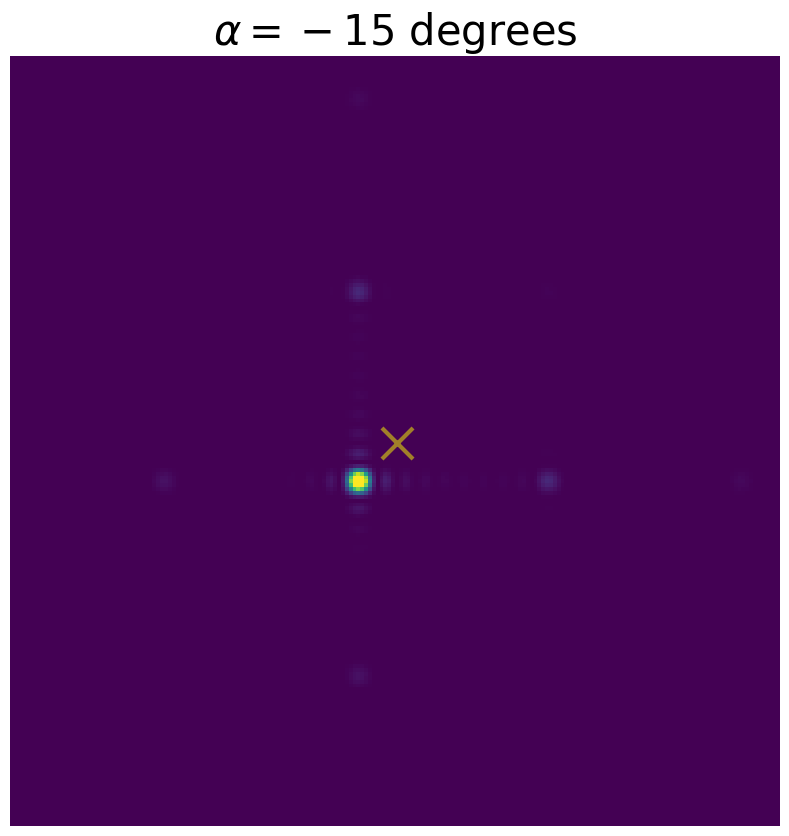

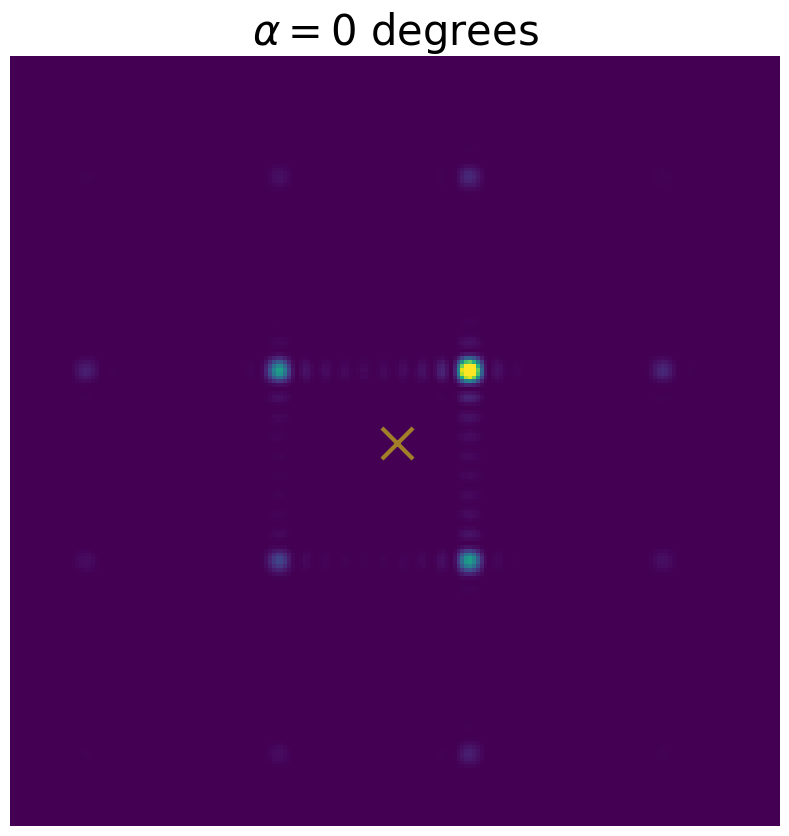

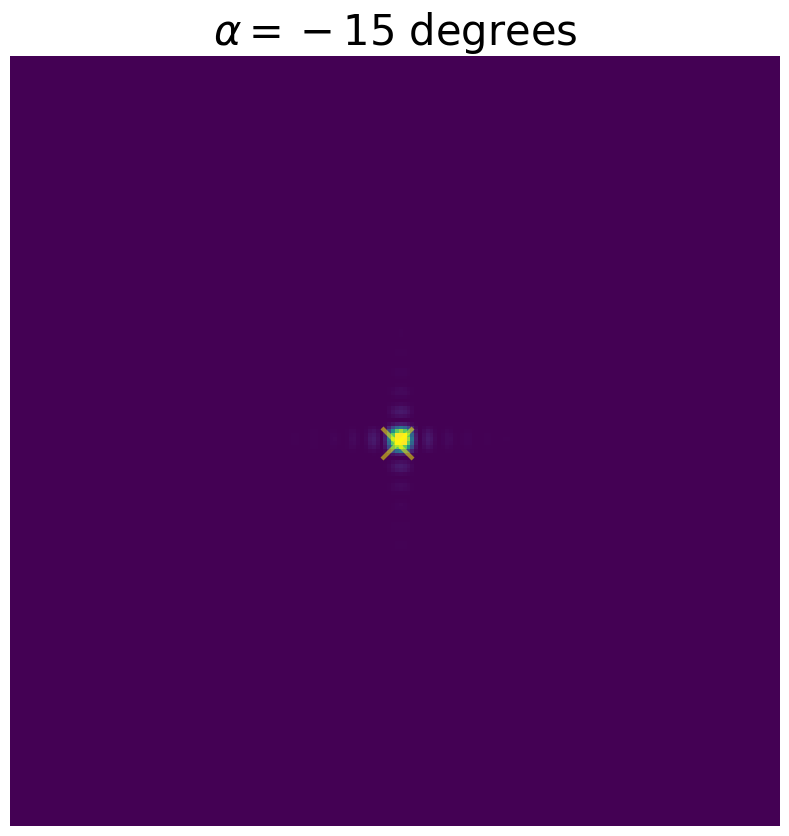

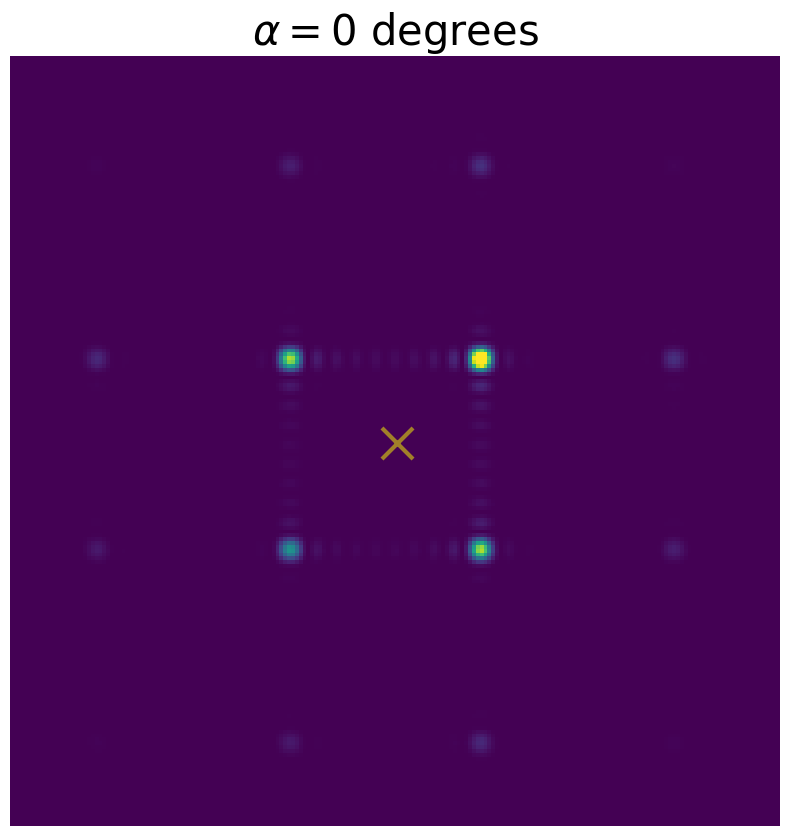

In [19]:
# alpha2 = 25./180*np.pi
show_2d(d = 7.6, theta = theta, _lambda = _lambda, alpha =  alpha1)
show_2d(d = 7.6, theta = theta, _lambda = _lambda, alpha =  alpha2)
show_2d(d = 10.8, theta = theta, _lambda = _lambda, alpha =  alpha1)
show_2d(d = 10.8, theta = theta, _lambda = _lambda, alpha =  alpha2)